In [2]:
%matplotlib inline

from __future__ import print_function, division
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
all_planets = pd.read_csv('data/all_planets.csv', comment='#')
fpp_data = pd.read_csv('data/fpp_final_table.csv')
new_validated = pd.read_csv('data/newly_validated.csv')

In [184]:
# Determine increase over previous, in given bins, from new discovery.
bins = [0.5000,0.7,1.1485,1.8843,3.0915,5.0721, 8.3216,13.6530,22.4000]

h0,b = np.histogram(all_planets.pl_rade, bins=bins)
h1,b = np.histogram(new_validated.rp, bins=bins)

print('bins edges: {}'.format(bins))
print('Previous numbers: {}'.format(h0))
print('Number newly validated: {}'.format(h1))

bins edges: [0.5, 0.7, 1.1485, 1.8843, 3.0915, 5.0721, 8.3216, 13.653, 22.4]
Previous numbers: [  8  89 319 413 140  43 164 131]
Number newly validated: [  9 130 409 504 139  43  39  11]


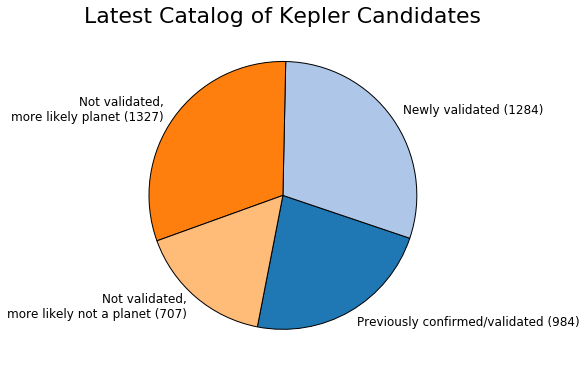

In [65]:
# Pie chart 
# Concept: all DR24 candidates + confirmed, wedges for prev. confirmed, newly confirmed, fpp > 0.5, fpp < 0.5

conf = fpp_data.disposition == 'CONFIRMED'
newval = fpp_data.koi.isin(new_validated.koi)
cand = fpp_data.disposition == 'CANDIDATE' 
cand_noval = cand & ~newval


fpp_thresh = 0.01 - 0.0006
fpp_boundary = 0.5

lo_fpp = fpp_data.FPP < fpp_boundary
hi_fpp = ~lo_fpp

cand_lofpp = cand_noval & lo_fpp
cand_hifpp = cand_noval & hi_fpp


categories = [conf, newval, cand_lofpp, cand_hifpp]

sums = np.array([c.sum() for c in categories])
fracs = sums / float(sums.sum()) * 100

names = ['Previously confirmed/validated']

labels = ['Previously confirmed/validated ({})'.format(sums[0]),
          'Newly validated ({})'.format(sums[1]),
          'Not validated,\nmore likely planet ({})'.format(sums[2]),
          'Not validated,\nmore likely not a planet ({})'.format(sums[3])]

#labels = ['Previously confirmed/validated ({})'.format(sums[0]),
#          'Newly validated ({})'.format(sums[1]),
#          'Not validated,\n>90% reliable ({})'.format(sums[2]),
#          'Not validated,\n<90% reliable({})'.format(sums[3])]


from settings import tableau20

colors = tableau20[:2] + tableau20[2:4]

fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.pie(fracs, labels=labels, startangle=-101, colors=colors);
ax.set_title('Latest Catalog of Kepler Candidates', fontsize=22)
fig.savefig('pie_chart.eps', bbox_inches='tight')
#fig.savefig('pie_chart_2.eps', bbox_inches='tight')

In [46]:
sums.sum()

4302

In [82]:
fpp_data[cand_noval].FPP.mean()

0.33252294721805631

In [83]:
cand_noval.sum()

2034

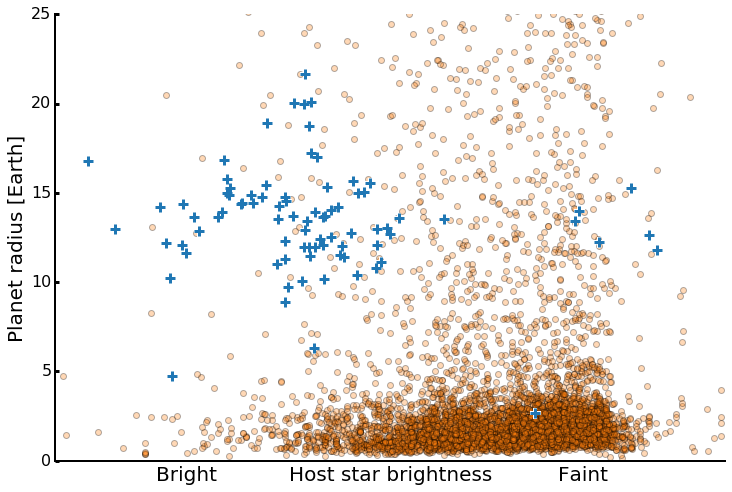

In [186]:
import matplotlib.pyplot as plt
from astropy import constants as const

RJUP = const.R_jup.cgs.value
REARTH = const.R_earth.cgs.value

from settings import tableau20
from data import exo,DR24

DR24.Vmag = DR24.koi_gmag - 0.59*(DR24.koi_gmag - DR24.koi_rmag) - 0.01

fig, ax = plt.subplots(1,1, figsize=(12,8))

ax.spines["top"].set_visible(False)    
ax.spines["right"].set_visible(False)  
#ax.spines["left"].set_visible(False)    
#ax.spines["bottom"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  

ground_pre_kepler = ~(exo.NAME.str.contains('Kepler') |
                       exo.NAME.str.contains('KOI') |
                       exo.NAME.str.contains('CoRoT')) & (exo.DATE < 2012) & (exo.STARDISCMETH=='Transit')

ax.plot(exo[ground_pre_kepler].V, exo[ground_pre_kepler].R * RJUP/REARTH, '+', color='w', ms=11, mew=4, zorder=2)
ax.plot(exo[ground_pre_kepler].V, exo[ground_pre_kepler].R * RJUP/REARTH, '+', color=tableau20[0], ms=10, mew=3, zorder=2)
ax.plot(DR24.Vmag, DR24.koi_prad, 'o', color=tableau20[2], mew=1, alpha=0.3, zorder=1)
ax.set_ylim(ymin=0, ymax=25)
ax.set_xlim(xmin=7.8, xmax=18)
ax.set_xticks([])
ax.xaxis.set_tick_params(width=3)
ax.yaxis.set_tick_params(width=3)
ax.tick_params(labelsize=16)

ax.set_xlabel('Host star brightness', size=20);
ax.set_ylabel('Planet radius [Earth]', size=20);
ax.annotate('Bright', xy=(0.15,-0.045), xycoords='axes fraction', size=20)
ax.annotate('Faint', xy=(0.75,-0.045), xycoords='axes fraction', size=20)
fig.savefig('ground_vs_kep.png', transparent=True)
fig.savefig('ground_vs_kep.eps', transparent=True)

In [92]:
ax.set_xticks?

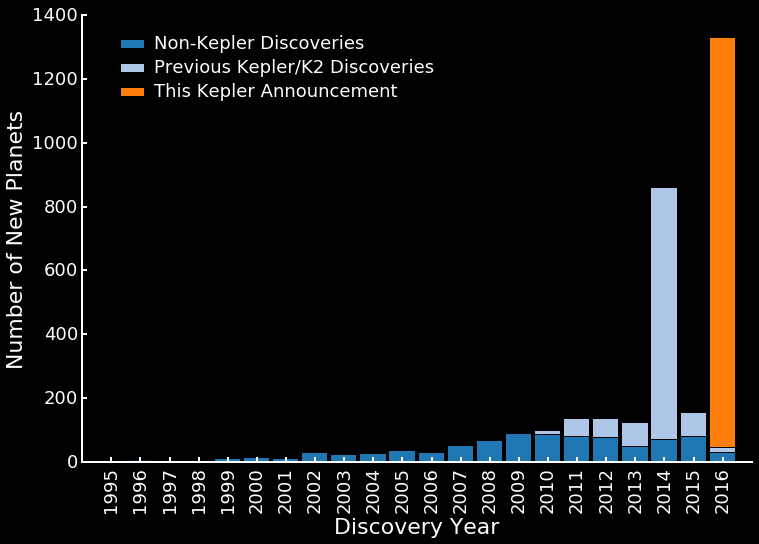

In [212]:
#Animated histogram
# Categories: non-kepler, kepler previous, kepler new

years = np.arange(1995,2017)
bins = years + 0.42

name_matches = ['Kepler', 'K2', 'PH', 'KIC', 'KOI']
kepler_mask = np.zeros(len(all_planets)).astype(bool)
for m in name_matches:
    kepler_mask |= all_planets.pl_hostname.str.match(m)

kepler = all_planets[kepler_mask]
non_kepler = all_planets[~kepler_mask]

non_kepler_dates = np.sort(non_kepler.pl_disc)
kepler_dates = np.sort(kepler.pl_disc)
new_dates = np.ones(1284)*2016

data = [non_kepler_dates,
        kepler_dates,
        new_dates]

colors = [tableau20[0], tableau20[1], tableau20[2]]
labels = ['Non-Kepler Discoveries',
          'Previous Kepler/K2 Discoveries ',
          'This Kepler Announcement']

def discovery_hist(data, years=years, colors=colors, labels=labels, legend=True):

    fig, ax = plt.subplots(1,1, figsize=(12,8), facecolor='black')
    ax.set_axis_bgcolor('black')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_color('white')
    ax.spines['left'].set_color('white')

    ax.title.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.xaxis.label.set_color('white')
    ax.tick_params(axis='x', colors='white', length=5)
    ax.tick_params(axis='y', colors='white', length=5)

    ax.tick_params(axis='both', direction='in')
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

    colors = colors[0:len(data)]
    labels = labels[0:len(data)]
    
    ax.hist(data, bins=bins, width=0.9, color=colors, stacked=True, label=labels)
    plt.xticks(years, rotation='vertical', color='w', size=18);
    ax.set_xlabel('Discovery Year', color='w', fontsize=22)
    ax.set_ylabel('Number of New Planets', size=22)
    ax.set_xlim(xmin=1994, xmax=2017)
    ax.tick_params(axis='both', which='major', labelsize=18, color='w')

    if legend:
        legend = ax.legend(loc=(0.05,0.8))
        legend.get_frame().set_facecolor('black')
        for text in legend.get_texts():
            plt.setp(text, color = 'w', size=18)
    
    return fig

fig = discovery_hist(data)
    
fig.savefig('discovery_year.png', bbox_inches='tight', facecolor=fig.get_facecolor(), edgecolor='none')

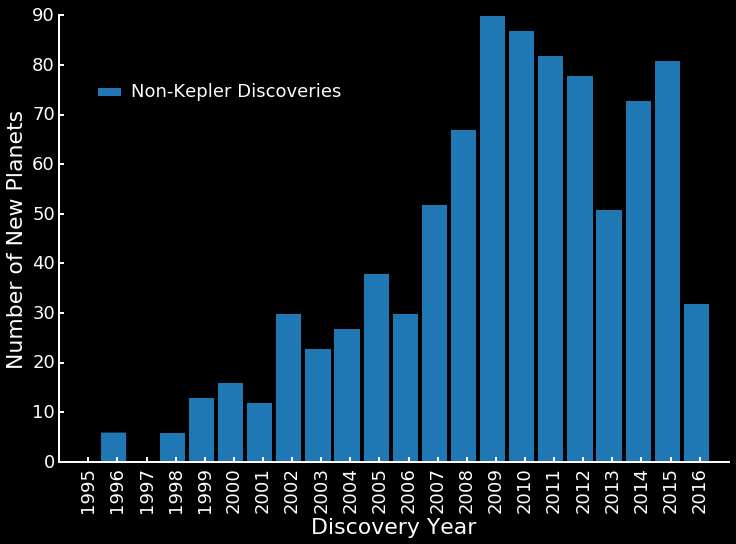

In [213]:
fig = discovery_hist([data[0],])

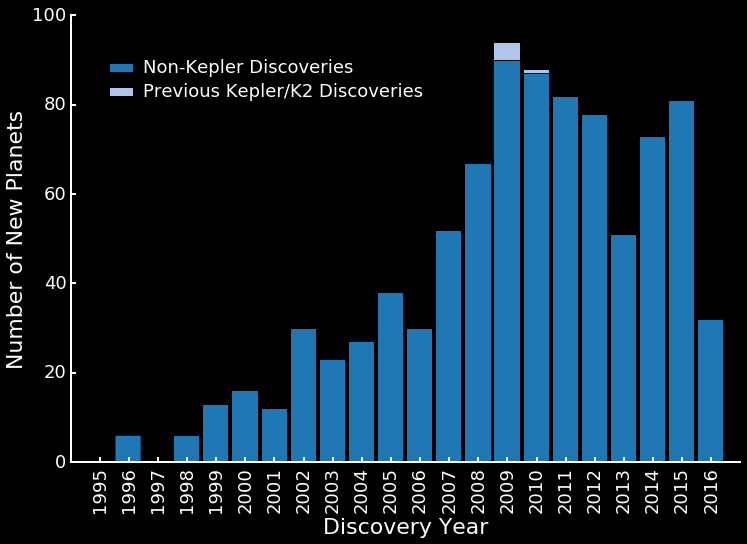

In [214]:
chunksize=5
fig = discovery_hist([non_kepler_dates, kepler_dates[:5]])